In [21]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import time

import utils

In [2]:
BATCH_SIZE = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
trans = transforms.ToTensor()
train_set = datasets.MNIST("data", train=True, download=True, transform=trans)
test_set = datasets.MNIST("data", train=False, download=True, transform=trans)

In [4]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=4)

test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=4)

torch.Size([1, 1, 28, 28])


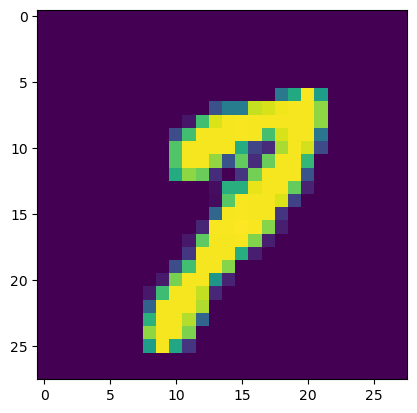

In [5]:
for (X, y) in train_loader:
    print(X.size())
    arr = X.numpy()
    arr = np.squeeze(arr, (0, 1))
    plt.imshow(arr)
    break

In [6]:
def beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02

    return torch.linspace(beta_start, beta_end, timesteps)

In [23]:
timesteps = 200
betas = beta_schedule(200)
alphas = 1.0 - betas

alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

sqrt_recip_alphas = torch.sqrt(1 / alphas)

posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

In [8]:
def extract(vec, t, x_shape):
    batch_size = t.shape[0]
    out = vec.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [18]:
def get_noisy_image(x_start, step):
    noise = torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, step, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, step, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [19]:
for (X, y) in train_loader:
    arr = [get_noisy_image(X, torch.tensor([t])) for t in [0, 50, 100, 150, 199]]
    utils.plot(arr)
    break

torch.Size([1, 1, 1, 1])
torch.Size([1, 1, 1, 1])
torch.Size([1, 1, 1, 1])
torch.Size([1, 1, 1, 1])
torch.Size([1, 1, 1, 1])


In [16]:
def get_denoised_image(x, step, model):
    betas_t = extract(betas, step, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, step, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, step, x.shape)

    model_mean = sqrt_recip_alphas_t * (x - betas_t  * model(x, step) / sqrt_one_minus_alphas_cumprod_t)

    if step == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        posterior_variance_t = extract(posterior_variance, step)
        return model_mean + noise * posterior_variance